In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler
from plotting.learning_curves import loss_plot

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:

exper_mc = ExperimentHandler.load_experiment("/home/jorg/repository/dcnn_acdc/logs/20180308_12_05_35_dcnn_mcv1_150000E_lr2e02")
# FIRST RUN: 20180306_14_58_12_dcnn_mc1v1_150000E_lr2e02 with p=0.1 with only one fold
# 20180308_12_06_25_dcnn_mcv1_150000E_lr2e02  with p=0.3
# 20180308_12_05_35_dcnn_mcv1_150000E_lr2e02  with p=0.1
exper_hdl_mc = ExperimentHandler(exper_mc, use_logfile=False)
exper_hdl_mc.set_root_dir("/home/jorg/repository/dcnn_acdc")

Load from /home/jorg/repository/dcnn_acdc/logs/20180308_12_05_35_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll


In [3]:
exper_base = ExperimentHandler.load_experiment("/home/jorg/repository/dcnn_acdc/logs/20180308_12_04_41_dcnnv1_150000E_lr2e02")

exper_hdl_base = ExperimentHandler(exper_base, use_logfile=False)
exper_hdl_base.set_root_dir("/home/jorg/repository/dcnn_acdc")

Load from /home/jorg/repository/dcnn_acdc/logs/20180308_12_04_41_dcnnv1_150000E_lr2e02/stats/exper_stats.dll


In [4]:
model_mc = exper_hdl_mc.load_checkpoint(verbose=False, drop_prob=0.1, checkpoint=120000)

INFO - INFO - loaded existing model from checkpoint /home/jorg/repository/dcnn_acdc/logs/20180308_12_05_35_dcnn_mcv1_150000E_lr2e02/checkpoints/BaseDilated2DCNNcheckpoint120000.pth.tar
INFO - INFO - loaded existing model from checkpoint /home/jorg/repository/dcnn_acdc/logs/20180308_12_05_35_dcnn_mcv1_150000E_lr2e02/checkpoints/BaseDilated2DCNNcheckpoint120000.pth.tar


In [5]:
model_base = exper_hdl_base.load_checkpoint(verbose=False, drop_prob=0.5)

INFO - INFO - loaded existing model from checkpoint /home/jorg/repository/dcnn_acdc/logs/20180308_12_04_41_dcnnv1_150000E_lr2e02/checkpoints/BaseDilated2DCNNcheckpoint150000.pth.tar
INFO - INFO - loaded existing model from checkpoint /home/jorg/repository/dcnn_acdc/logs/20180308_12_04_41_dcnnv1_150000E_lr2e02/checkpoints/BaseDilated2DCNNcheckpoint150000.pth.tar


In [15]:
dataset = ACDC2017DataSet(exper_config=exper_hdl.exper.config, search_mask=exper_hdl.exper.config.dflt_image_name + ".mhd", 
                          fold_ids=[2],
                          preprocess=False, debug=False)

  1%|▏         | 1/75 [00:00<00:10,  6.83it/s]

INFO - Using folds [2] - busy loading images/references...this may take a while!
INFO - >>> Search for /home/jorg/repository/dcnn_acdc/data/Folds/fold2/train/images_iso/*patient*.mhd <<<


100%|██████████| 25/25 [00:02<00:00, 10.94it/s]

INFO - Using folds [2] - loaded 200 files: 2892 slices in train set, 912 slices in validation set


In [6]:
test_set = ACDC2017TestHandler(exper_config=exper_hdl_base.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[0],
                               debug=False, batch_size=2, use_cuda=True)

  0%|          | 0/2 [00:00<?, ?it/s]

INFO - Testhandler - >>> Search for /home/jorg/repository/dcnn_acdc/data/Folds/fold0/train/images/*patient*.mhd <<<
INFO - File list contains 200 files
0 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/train/images/patient001_frame01.mhd


/home/jorg/anaconda2/envs/pyt_0_3_0/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


1 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/train/images/patient001_frame12.mhd


 50%|█████     | 1/2 [00:00<00:00,  1.42it/s]

2 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/train/images/patient002_frame01.mhd
3 - /home/jorg/repository/dcnn_acdc/data/Folds/fold0/train/images/patient002_frame12.mhd


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

INFO - Successfully loaded 2 ED/ES patient pairs


In [10]:
exper_hdl_base.test_results = None
exper_hdl_base.test(model_base, test_set, image_num=1, sample_weights=True, mc_samples=20, compute_hd=True)

('b_predictions ', (20, 8, 227, 250, 10))
Test accuracy: test loss -1.359	 dice(RV/Myo/LV): ES 0.46/0.83/0.87 --- ED 0.60/0.81/0.91
Test accuracy: test loss -1.359	 Hausdorff(RV/Myo/LV): ES 205.40/150.60/179.80 --- ED 272.94/183.91/210.92


In [7]:
exper_hdl_mc.test_results = None
exper_hdl_mc.test(model_mc, test_set, image_num=1, sample_weights=True, mc_samples=40, compute_hd=True)

Test accuracy: test loss -1.502	 dice(RV/Myo/LV): ES 0.59/0.85/0.92 --- ED 0.90/0.84/0.95
Test accuracy: test loss -1.502	 Hausdorff(RV/Myo/LV): ES 185.76/149.90/152.70 --- ED 203.54/147.28/162.27


In [13]:
exper_hdl_base.test_results.error_distribution()

In [8]:
exper_hdl_mc.test_results.error_distribution()

In [ ]:
from scipy.stats import entropy

probs_per_cls = exper_hdl_mc.test_results.probs_per_cls[0]

bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
p_dist, p_ranges = np.histogram(probs_per_cls["es_err"][3], bins=bins, density=True)
print("Entropy errors {:.3}".format(entropy(p_dist)))
p_dist, p_ranges = np.histogram(probs_per_cls["es_cor"][3], bins=bins, density=True)
print("Entropy correct {:.3}".format(entropy(p_dist)))

In [99]:
len(probs_per_cls["ed_err"])

3

Number of subplots 10 columns 5 rows 2 slices 3,4


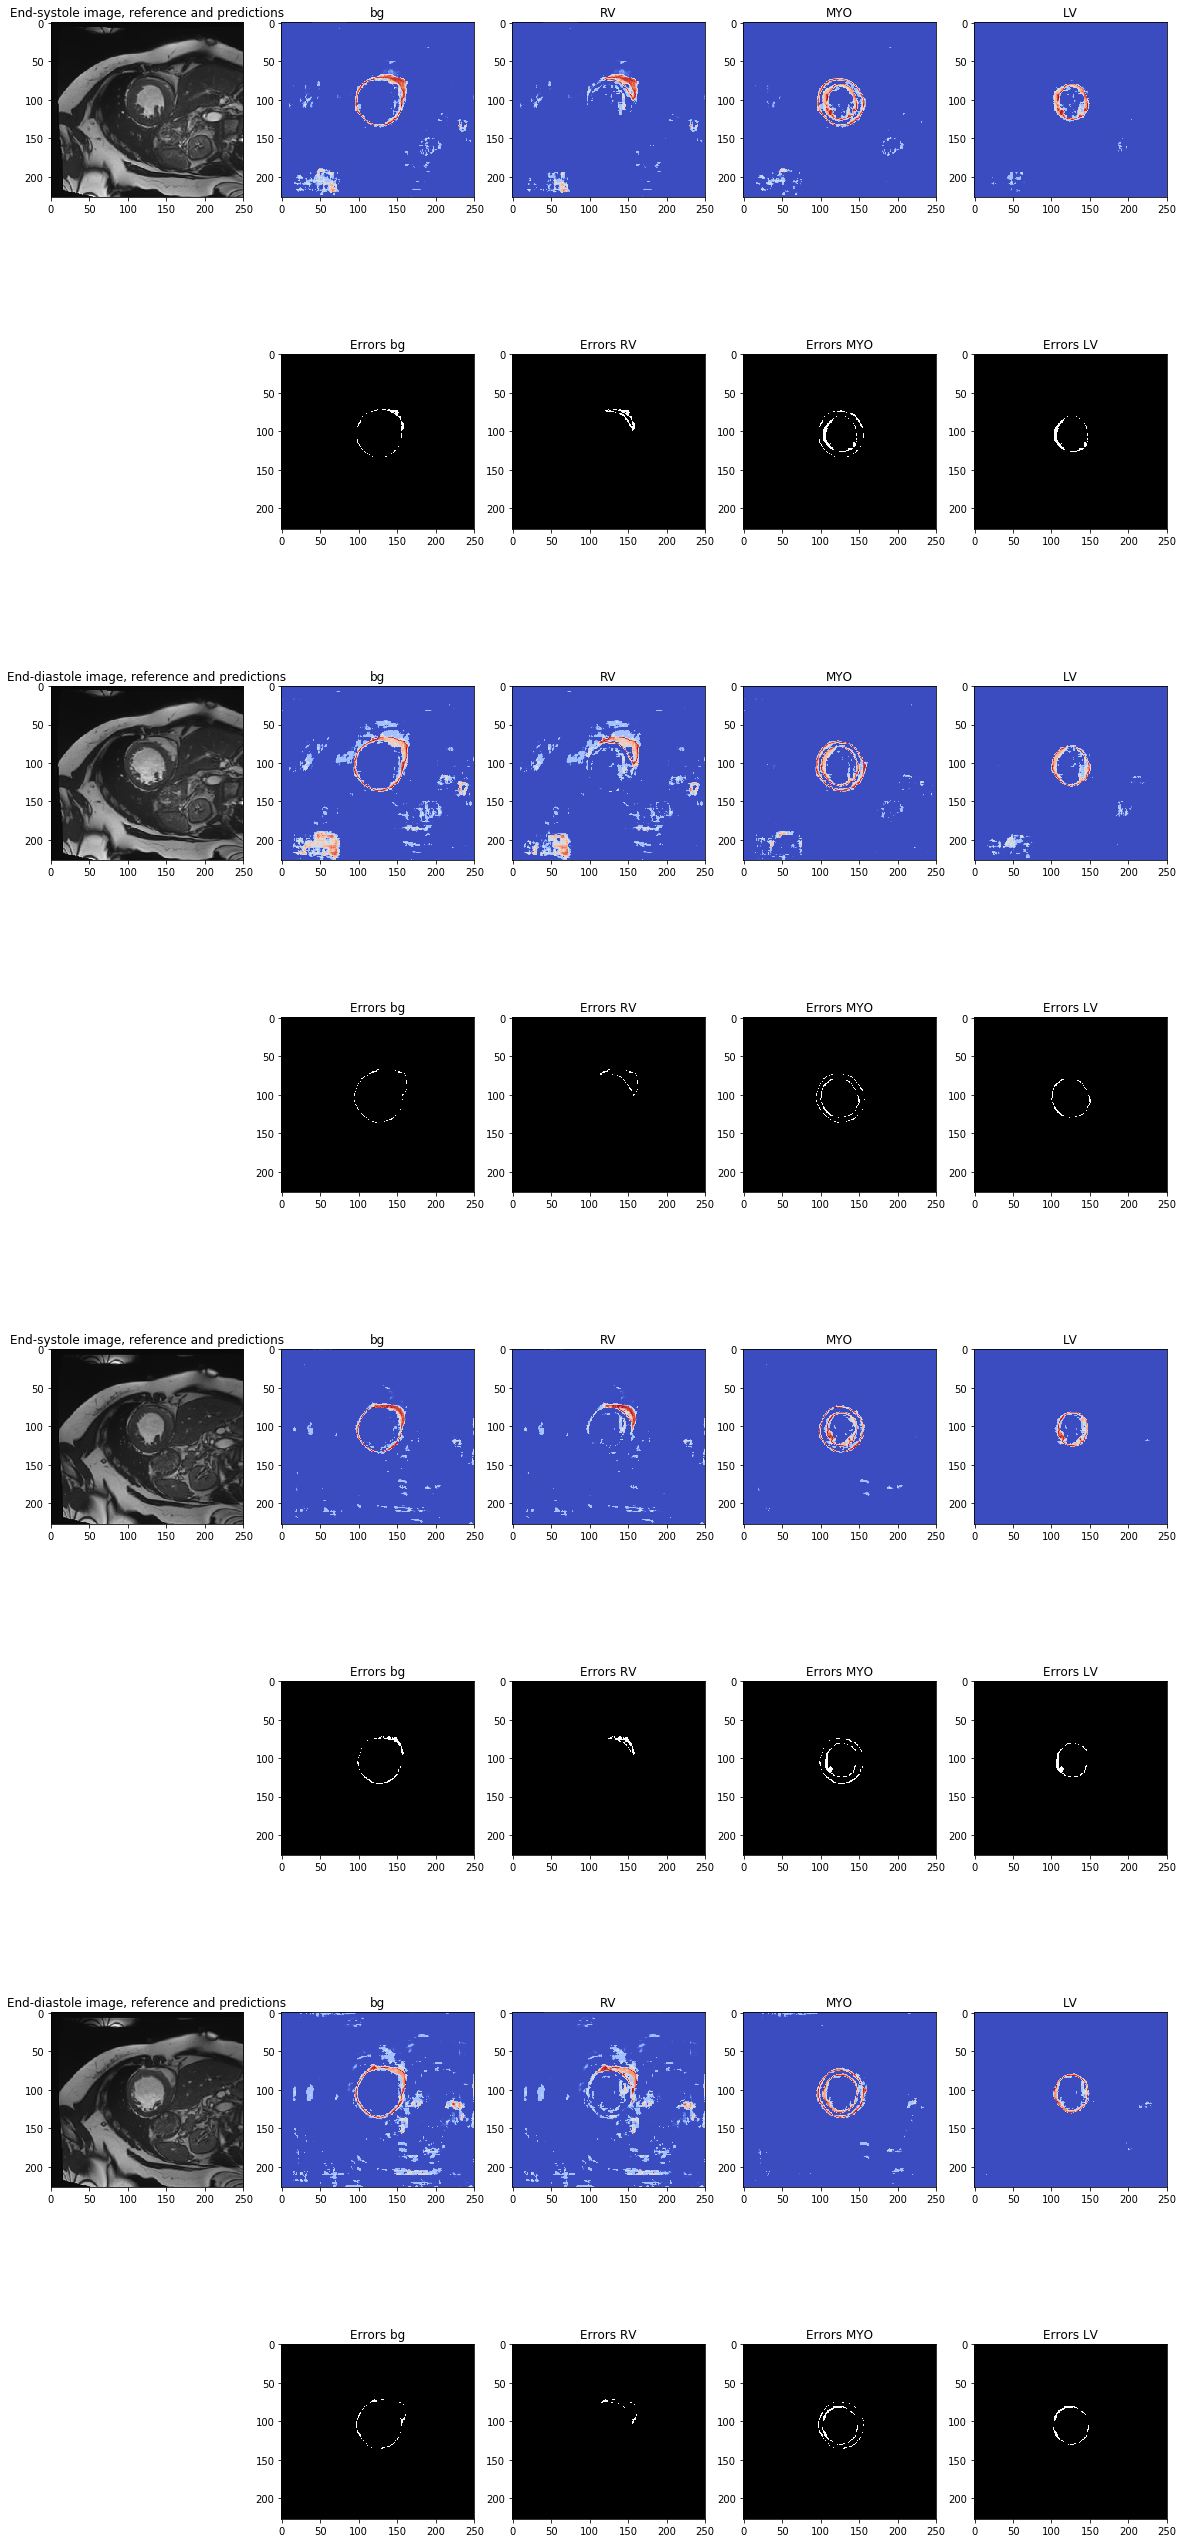

In [9]:
test_set.visualize_uncertainty(width=20, height=60, slice_range=[3,4])

In [13]:
def val_run(exper_hdl, dcnn_model, dataset, image_num=1):
    
    val_batch = TwoDimBatchHandler(exper_hdl.exper, batch_size=5)
    val_batch.generate_batch_2d(dataset.images(), dataset.labels())
    test_loss, test_pred = dcnn_model.do_test(val_batch.get_images(), val_batch.get_labels(),
                                                voxel_spacing=1.4, compute_hd=True, test_mode=True)
    val_batch.set_pred_labels(test_pred)
    test_accuracy = dcnn_model.get_accuracy()
    dice_loss_es, dice_loss_ed = dcnn_model.get_dice_losses(average=True)
    hd_stats, test_hausdorff = dcnn_model.get_hausdorff()
    # print("Hausdorff {}".format(np.array_str(hd_stats.flatten(), precision=3)))
    print("Test accuracy: test loss {:.3f}\t "
                                  "dice-coeff:: ES {:.3f}/{:.3f}/{:.3f} --- "
                                  "ED {:.3f}/{:.3f}/{:.3f}".format(test_loss.data.cpu().numpy()[0],
                                                                   test_accuracy[0], test_accuracy[1],
                                                                   test_accuracy[2], test_accuracy[3],
                                                                   test_accuracy[4], test_accuracy[5]))
    del val_batch
    
    return test_loss, hd_stats, test_hausdorff, test_accuracy

test_loss, hd_stats, test_hd, test_accuracy = val_run(exper_hdl, model, dataset)


Test accuracy: test loss -3.596	 dice-coeff:: ES 0.862/0.844/0.835 --- ED 0.910/0.823/0.933


In [40]:
def test_run(dcnn_model, test_set, image_num=1, sample_weights=True):
    slice_counter = 0
    for batch_image, batch_labels in test_set.batch_generator(image_num):
        
        pytorch_test_mode = not sample_weights
        test_loss, test_pred = dcnn_model.do_test(batch_image, batch_labels,
                                                voxel_spacing=1.4, compute_hd=True, test_mode=pytorch_test_mode)
        test_set.set_pred_labels(test_pred)
        print(batch_labels.shape, test_pred.shape)
        dice_loss_es, dice_loss_ed = dcnn_model.get_dice_losses(average=True)
        hd_stats, test_hausdorff = dcnn_model.get_hausdorff()
    # print("Hausdorff {}".format(np.array_str(hd_stats.flatten(), precision=3)))
    test_accuracy = test_set.get_accuracy()
    print("Test accuracy: test loss {:.3f}\t "
                                  "dice(RV/Myo/LV): ES {:.3f}/{:.3f}/{:.3f} --- "
                                  "ED {:.3f}/{:.3f}/{:.3f}".format(test_loss.data.cpu().numpy()[0],
                                                                   test_accuracy[1], test_accuracy[2],
                                                                   test_accuracy[3], test_accuracy[5],
                                                                   test_accuracy[6], test_accuracy[7]))
        # val_batch.save_batch_img_to_files()
    return test_loss, hd_stats, test_hausdorff, test_accuracy

test_loss, hd_stats, test_hd, test_accuracy = test_run(model, test_set, image_num=1, sample_weights=False)


torch.Size([1, 8, 227, 250]) torch.Size([1, 8, 227, 250])
torch.Size([1, 8, 227, 250]) torch.Size([1, 8, 227, 250])
torch.Size([1, 8, 227, 250]) torch.Size([1, 8, 227, 250])
torch.Size([1, 8, 227, 250]) torch.Size([1, 8, 227, 250])
torch.Size([1, 8, 227, 250]) torch.Size([1, 8, 227, 250])
torch.Size([1, 8, 227, 250]) torch.Size([1, 8, 227, 250])
torch.Size([1, 8, 227, 250]) torch.Size([1, 8, 227, 250])
torch.Size([1, 8, 227, 250]) torch.Size([1, 8, 227, 250])
torch.Size([1, 8, 227, 250]) torch.Size([1, 8, 227, 250])
torch.Size([1, 8, 227, 250]) torch.Size([1, 8, 227, 250])
Test accuracy: test loss -2.488	 dice(RV/Myo/LV): ES 0.695/0.867/0.936 --- ED 0.932/0.870/0.957


Number of subplots 20 columns 5 rows 4 slices 5,6,7,8,9
counter 1
counter 21
counter 41
counter 61
counter 81


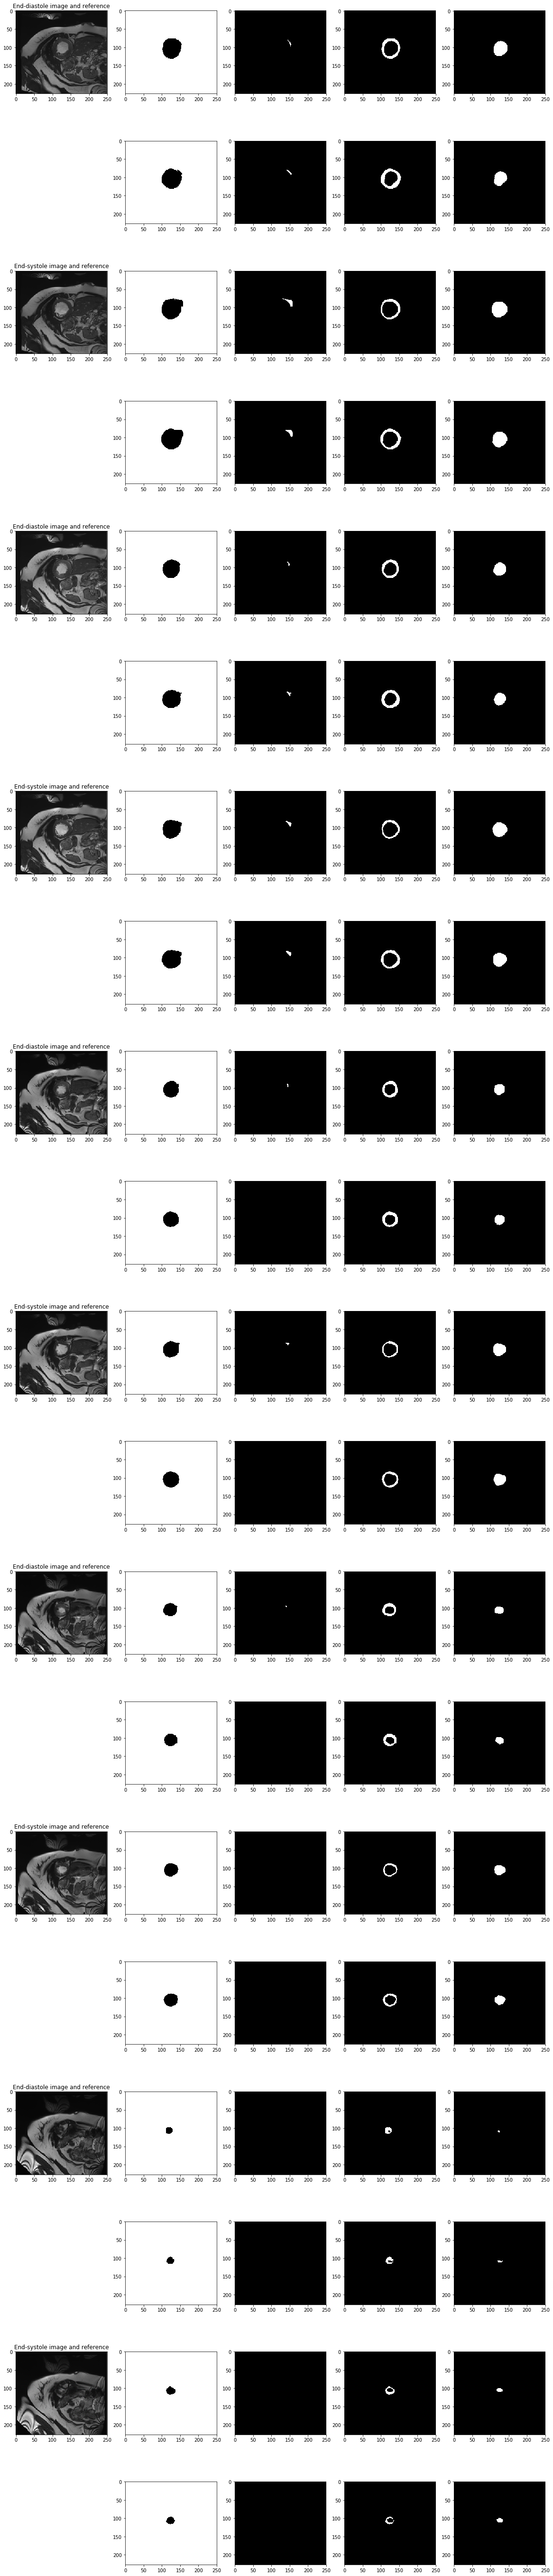

In [22]:
test_set.visualize_test_slices(width=20, height=100, slice_range=np.arange(5, 10))

In [ ]:
test_set.generate_batch(image_num=1, use_labels=True)

for batch_image, batch_labels in test_set.batch_generator():
    batch_image = batch_image.data.cpu().numpy()
    print(batch_image.shape)
    plt.imshow(batch_image[0,0], cmap=cm.gray)
    plt.show()


In [ ]:
loss_plot(exper, width=18, validation=True, log_scale=False,
          save=False, do_average=True) #, epoch_range=[40001, 50000])

In [20]:
test_set.save_batch_img_to_files(slice_range=[5], wo_padding=True, save_dir="/home/jorg/tmp/")

Successfully saved image to /home/jorg/tmp/06_img_ph_es.nii
Successfully saved image to /home/jorg/tmp/06_lbl_phes_cls1.nii
Successfully saved image to /home/jorg/tmp/06_pred_lbl_phes_cls1.nii
Successfully saved image to /home/jorg/tmp/06_lbl_phes_cls2.nii
Successfully saved image to /home/jorg/tmp/06_pred_lbl_phes_cls2.nii
Successfully saved image to /home/jorg/tmp/06_lbl_phes_cls3.nii
Successfully saved image to /home/jorg/tmp/06_pred_lbl_phes_cls3.nii
Successfully saved image to /home/jorg/tmp/06_img_ph_ed.nii
Successfully saved image to /home/jorg/tmp/06_lbl_phed_cls1.nii
Successfully saved image to /home/jorg/tmp/06_pred_lbl_phed_cls1.nii
Successfully saved image to /home/jorg/tmp/06_lbl_phed_cls2.nii
Successfully saved image to /home/jorg/tmp/06_pred_lbl_phed_cls2.nii
Successfully saved image to /home/jorg/tmp/06_lbl_phed_cls3.nii
Successfully saved image to /home/jorg/tmp/06_pred_lbl_phed_cls3.nii


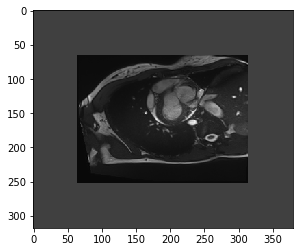

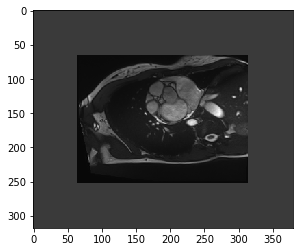

In [15]:
from in_out.read_save_images import load_mhd_to_numpy

idx = 888
image = dataset.images(train=True)[idx]
img_ed = image[0]
img_es = image[1]
plt.imshow(img_es, cmap=cm.gray)
plt.show()

plt.imshow(img_ed, cmap=cm.gray)
plt.show()